In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate , train_test_split , StratifiedShuffleSplit, cross_val_score
from sklearn import   linear_model, metrics
from sklearn.linear_model import SGDClassifier as SGD

In [3]:
train_directory = "data1/train.csv"

train = pd.read_csv(train_directory, header=0 )

train['y'] = [1 if y == 'yes' else 0 for y in train['y']]

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             3222 non-null   int64  
 1   job             3222 non-null   object 
 2   marital         3222 non-null   object 
 3   education       3222 non-null   object 
 4   default         3222 non-null   object 
 5   housing         3222 non-null   object 
 6   loan            3222 non-null   object 
 7   contact         3222 non-null   object 
 8   month           3222 non-null   object 
 9   day_of_week     3222 non-null   object 
 10  duration        3222 non-null   int64  
 11  campaign        3222 non-null   int64  
 12  pdays           3222 non-null   int64  
 13  previous        3222 non-null   int64  
 14  poutcome        3222 non-null   object 
 15  emp.var.rate    3222 non-null   float64
 16  cons.price.idx  3222 non-null   float64
 17  cons.conf.idx   3222 non-null   f

Видно, что графы 1-9 и 14 имеют тип object. Запишем все числовые графы в отдельный список

In [5]:
not_object_features = ['age' , 'previous', 'duration', 'campaign', 'pdays', 'emp.var.rate', 'cons.price.idx', 
                       'cons.conf.idx', 'euribor3m', 'nr.employed']

In [6]:
X = train[not_object_features][:]
y = train['y'][:]

In [7]:
classifier = RandomForestClassifier(random_state=17)

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, 
                                                                                     test_size = 0.2)

In [9]:
classifier.fit(train_data , train_labels)

RandomForestClassifier(random_state=17)

In [10]:
pred_labels = classifier.predict_proba(test_data)[:, 1]
pred_labels2 = classifier.predict(test_data)

In [11]:
print(metrics.roc_auc_score(test_labels, pred_labels))
print(metrics.roc_auc_score(test_labels, pred_labels2))

0.9287865748709122
0.7067690404475044


Кросс валидация с перемешиванием, 5 фолдов

In [12]:
sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 17)

In [13]:
cross_val_score(classifier, X, y, cv=sss, scoring='roc_auc').mean()

0.9210951134380455

In [14]:
results = []
for train_index, test_index in sss.split(X, y):
    train_data, test_data = X.iloc[train_index], X.iloc[test_index]
    train_labels, test_labels = y[train_index], y[test_index]
    classifier.fit(train_data , train_labels)
    pred_labels = classifier.predict(test_data)
    results.append(metrics.roc_auc_score(test_labels, pred_labels))
best = np.array(results).mean()*100 
print("ROC_AUC_SCORE = : {:.2f}%".format(best))  

ROC_AUC_SCORE = : 72.98%


Построим boxplot'ы для всех числовых признаков:

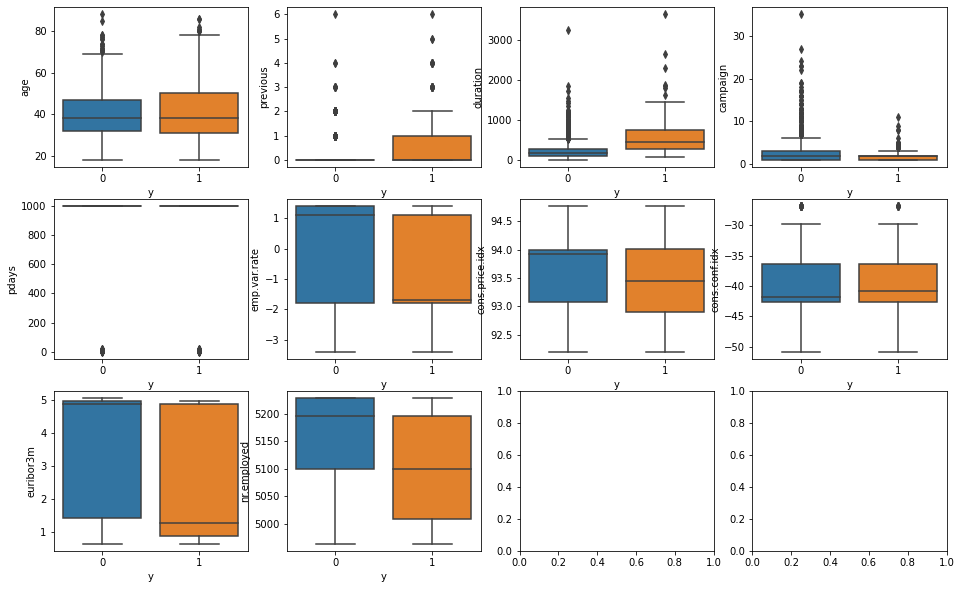

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, feat in  enumerate(not_object_features):
    sns.boxplot(x='y', y=feat, data=train, ax=axes[int(idx / 4), idx % 4])
    axes[int(idx / 4), idx % 4].set_xlabel('y')
    axes[int(idx / 4), idx % 4].set_ylabel(feat);

На глаз видна разница между боксплотами для признаком previous, duration, campaign, emp.var.rate, cons.price.idx, euribor3m, nr.employed. Запишем их в отдельный список:

In [16]:
features = ['previous', 'duration', 'campaign', 'emp.var.rate', 'cons.price.idx', 
                       'euribor3m', 'nr.employed']

In [17]:
X = train[features][:]
y = train['y'][:]

In [18]:
classifier = RandomForestClassifier(random_state=17)

In [19]:
sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 17)

In [20]:
np.mean(cross_val_score(classifier, X, y, cv=sss, scoring='roc_auc'))

0.9082412255187124

In [21]:
results = []
for train_index, test_index in sss.split(X, y):
    train_data, test_data = X.iloc[train_index], X.iloc[test_index]
    train_labels, test_labels = y[train_index], y[test_index]
    classifier.fit(train_data , train_labels)
    pred_labels = classifier.predict(test_data)
    results.append(metrics.roc_auc_score(test_labels, pred_labels))
best = np.array(results).mean()*100 
print("ROC_AUC_SCORE = : {:.2f}%".format(best))

ROC_AUC_SCORE = : 70.80%


Запишем в отдельный список все категориальные признаки:

In [22]:
object_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                   'contact', 'month', 'day_of_week', 'poutcome']

Отобразим все категорильные признаки в виде countplot'ов

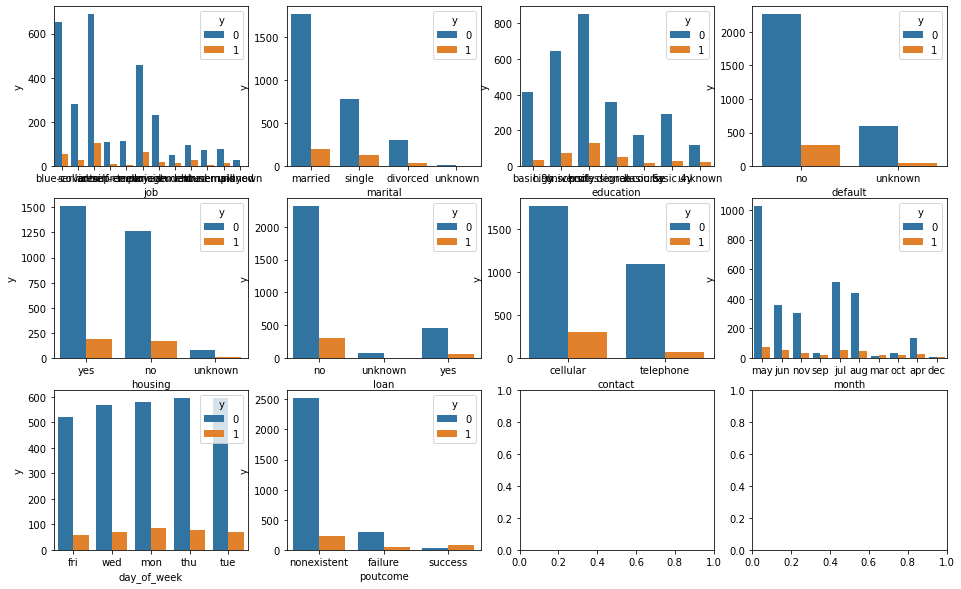

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, feat in  enumerate(object_features):
    sns.countplot(x=feat, hue='y', data=train, ax=axes[int(idx / 4), idx % 4]);
    axes[int(idx / 4), idx % 4].set_ylabel('y')
    axes[int(idx / 4), idx % 4].set_xlabel(feat);

Преобразуем все категориальные признаки в числовые. Сразу видно, что сильным признаком может являться poutcome: при значении success число выходов в просрок возрастает. Также видно, что при двух значениях job число выходов в просрок возрастает (retired и student). Еще можно проверить увеличится ли прогноз, если добавить признак является ли месяц сентябрем, мартом или октябрем, потому что в эти три месяца плохое соотношение числа выхода в просрок и платежа. 

In [24]:
train_directory = "data1/train.csv"

train = pd.read_csv(train_directory, header=0 )

train['y'] = [1 if y == 'yes' else 0 for y in train['y']]
train['loan'] = train['loan'].map({'no': 0, 'yes': 1, 'unknown': 2})
train['poutcome'] = train['poutcome'].map({'nonexistent': 0, 'failure': 0, 'success': 1})
months = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 
          'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
jobs = {'admin.': 0, 'blue-collar': 1, 'technician': 2, 'services': 3, 'management': 4, 'retired': 5, 
        'self-employed': 6, 'entrepreneur': 7, 'unemployed': 8, 'housemaid': 9, 'student': 10, 'unknown': 11}
educations = {'basic.4y': 0, 'basic.6y': 1, 'basic.9y': 2, 'high.school': 3, 
              'professional.course': 4, 'university.degree': 5, 'unknown': 6}
days = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7}
train['month'] = train['month'].map(months)
train['day_of_week'] = train['day_of_week'].map(days)
train['job'] = train['job'].map(jobs)
train['education'] = train['education'].map(educations)
train['is_retired'] = train['job'].apply(lambda job: 1 if (job==5) else 0)
train['is_student'] = train['job'].apply(lambda job: 1 if (job==10) else 0)
train['month_sep_oct'] = train['month'].apply(lambda month: 1 if (month==9) or (month==10) else 0)
train['marital'] = train['marital'].apply(lambda marital: 1 if (marital=='married') else 0)
train['contact'] = train['contact'].apply(lambda contact: 1 if (contact=='cellular') else 0)
train['default'] = train['default'].apply(lambda default: 1 if (default=='no') else 0)
train['housing'] = train['housing'].apply(lambda housing: 1 if (housing=='yes') else 0)
train['period'] = train['month'].map({1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3, 8: 3, 9: 4, 10: 4, 11: 4, 12: 1})

In [25]:
object_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'period',
                   'contact', 'month', 'day_of_week', 'poutcome', 'is_retired', 'is_student']

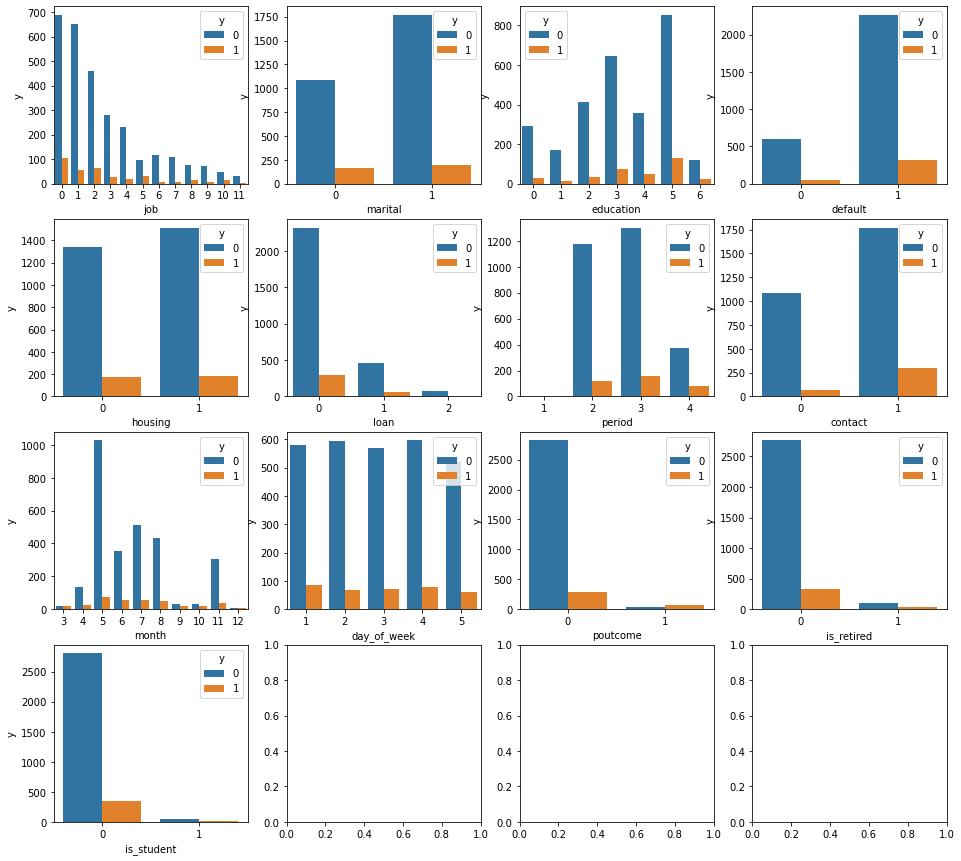

In [26]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 15))

for idx, feat in  enumerate(object_features):
    sns.countplot(x=feat, hue='y', data=train, ax=axes[int(idx / 4), idx % 4]);
    axes[int(idx / 4), idx % 4].set_ylabel('y')
    axes[int(idx / 4), idx % 4].set_xlabel(feat);

Ниже список, который составлен из признаков, по графикам которых видно, что они влияют на выход в просрок.

In [27]:
features = ['previous', 'duration', 'campaign', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 
            'nr.employed', 'poutcome', 'contact', 'period', 'is_retired', 'is_student']

In [28]:
X = train[features][:]
y = train['y'][:]

In [29]:
classifier = RandomForestClassifier(random_state=17)

In [30]:
sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 17)

In [31]:
np.mean(cross_val_score(classifier, X, y, cv=sss, scoring='roc_auc'))

0.9223385689354275

In [32]:
results = []
for train_index, test_index in sss.split(X, y):
    train_data, test_data = X.iloc[train_index], X.iloc[test_index]
    train_labels, test_labels = y[train_index], y[test_index]
    classifier.fit(train_data , train_labels)
    pred_labels = classifier.predict(test_data)
    results.append(metrics.roc_auc_score(test_labels, pred_labels))
best = np.array(results).mean()*100 
print("ROC_AUC_SCORE = : {:.2f}%".format(best))  

ROC_AUC_SCORE = : 73.51%


Проверим, какие значения предсказаний будут при всех признаках

In [33]:
all_features = list(train)
all_features.remove('y')

In [34]:
X = train[all_features][:]
y = train['y'][:]

In [35]:
classifier = RandomForestClassifier(random_state=17)

In [36]:
sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 17)

In [37]:
np.mean(cross_val_score(classifier, X, y, cv=sss, scoring='roc_auc'))

0.9295108590265659

In [38]:
results = []
for train_index, test_index in sss.split(X, y):
    train_data, test_data = X.iloc[train_index], X.iloc[test_index]
    train_labels, test_labels = y[train_index], y[test_index]
    classifier.fit(train_data , train_labels)
    pred_labels = classifier.predict(test_data)
    results.append(metrics.roc_auc_score(test_labels, pred_labels))
best = np.array(results).mean()*100 
print("ROC_AUC_SCORE = : {:.2f}%".format(best))  

ROC_AUC_SCORE = : 70.65%
